In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import math
from shapely.geometry.polygon import LineString, Point
from deepracer.logs import PlottingUtils as pu
from deepracer.tracks import TrackIO, Track
tu = TrackIO()

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

Loaded 155 waypoints


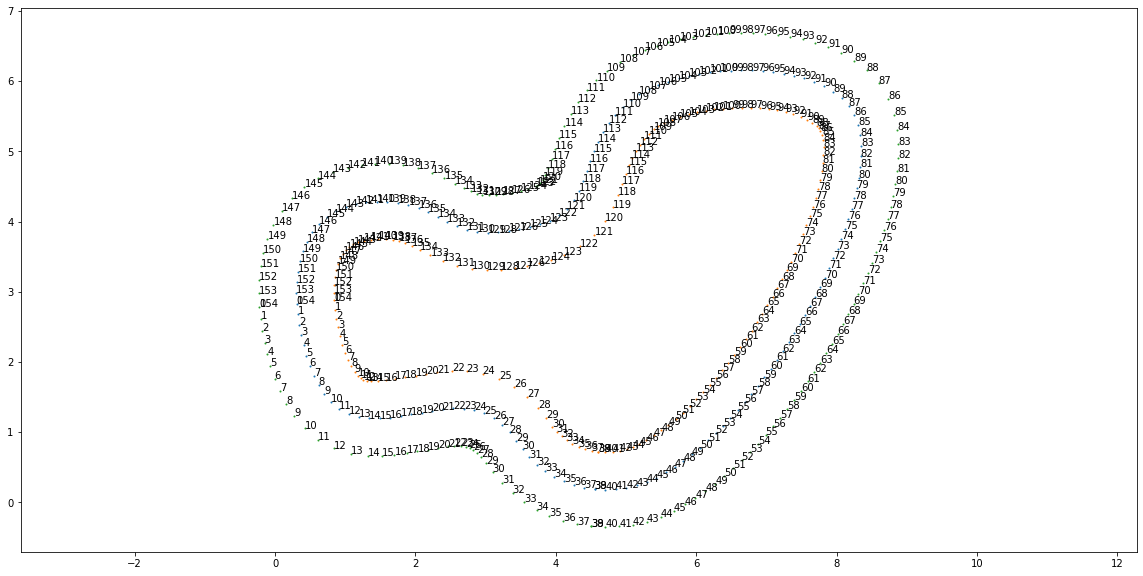

In [2]:
track: Track = tu.load_track("reInvent2019_track")
pu.plot_trackpoints(track)

In [3]:
dist=[]
track_line = track.center_line
for i in np.arange(len(track_line[:-1])):
    j = ((i+2) % len(track_line))-1
    dist.append(np.linalg.norm(track_line[j] - track_line[i]))

print('Total distance of track: %.1f' % sum(dist))

track_width = np.linalg.norm((track.inner_border-track.outer_border)[0])
print(f'Track width is {track_width:.5f}')

Total distance of track: 23.1
Track width is 1.06680


In [4]:
# Without using premade Plotting utils class functions
# Easier to just use premade functions

# waypoints = np.load("tracks/reInvent2019_track.npy")
# center = [[line[0],line[1]] for line in waypoints]
# center = list(map(tuple,center))
# left = [[line[2],line[3]] for line in waypoints]
# left = list(map(tuple,left))
# right = [[line[4],line[5]] for line in waypoints]
# right = list(map(tuple,right))

# Visualise the Track and Create Functions

## Generate Directional Angle Array

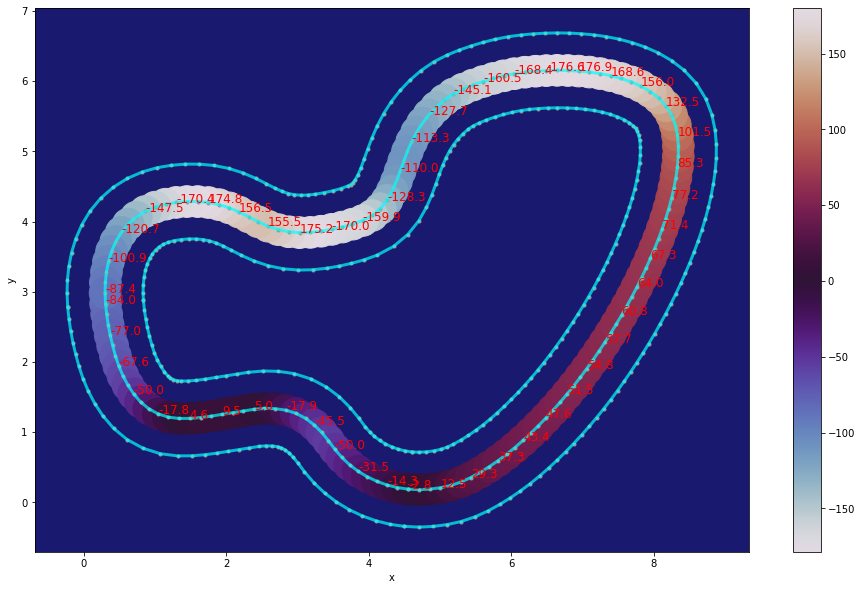

In [5]:
# Every point calculate the angular difference of track direction with 1 spacing between points
def track_dir(track_line,track,spacing=1,visualize=False):
    track_line = track_line[:-1]
    coord_diff = []
    track_angle = []
    for i in np.arange(len(track_line)):
        j = ((i+spacing+1) % len(track_line))-1
        coord_diff.append(list(track_line[j] - track_line[i]))
        track_angle.append(math.degrees(math.atan2(coord_diff[i][1],coord_diff[i][0])))
    
    if visualize == True:
        fig = plt.figure(figsize=(16, 10))
        ax = fig.add_subplot(1, 1, 1)

        ax.set_facecolor('midnightblue')

        line = LineString(track.inner_border)
        pu._plot_coords(ax, line)
        pu._plot_line(ax, line)

        line = LineString(track.outer_border)
        pu._plot_coords(ax, line)
        pu._plot_line(ax, line)
        
        line = LineString(track.center_line)
        pu._plot_coords(ax, line)
        pu._plot_line(ax, line)
        
        for i, p in enumerate(track_line[:]):
                if i % 3 == 0:
                    ax.annotate("{:.1f}".format(track_angle[i]), (p[0], p[1]), color='r',size=12)
                    
        pd.DataFrame(track_line[:],columns=list('xy')).plot.scatter('x','y',ax=ax, s=1000, c=track_angle,
                                cmap=plt.get_cmap('twilight'))
        
    # Closed loop requirement
    track_angle.append(track_angle[0])
    
    #track_angle has values from -180 to 180 w.r.t x-axis
    #it's the same as params['heading'] / yaw variable
    return track_angle

track_angle = track_dir(track.center_line,track,visualize = True)

## Calculate the Direction Angular Difference

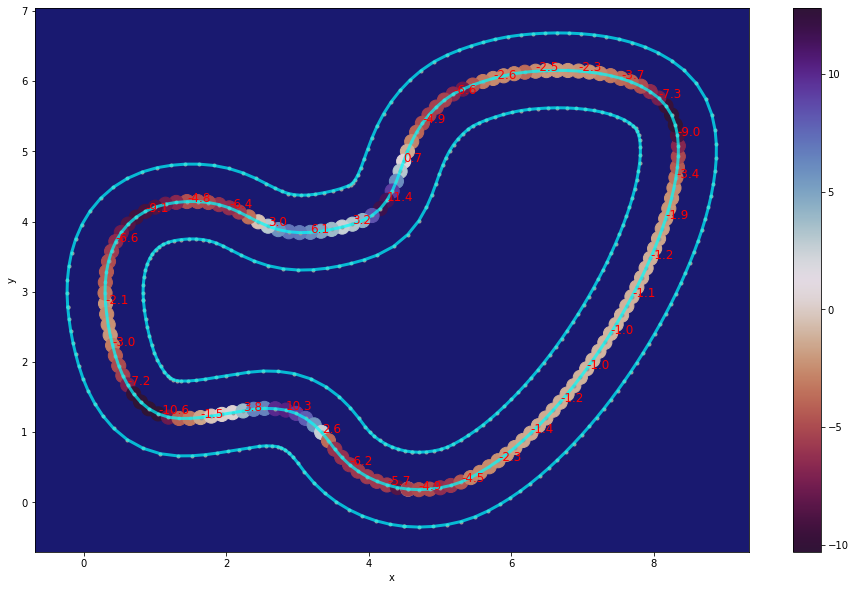

In [6]:
def track_angle_change(track_angle, track_line, track, visualize = True):
    track_line = track_line[:-1]
    track_angle = track_angle[:-1]
    def getAngleDifference(b1, b2):
        r = (b2 - b1) % 360.0
        # Python modulus has same sign as divisor, which is positive here,
        # so no need to consider negative case
        if r >= 180.0:
            r -= 360.0
        return r

    track_angle_diff = [getAngleDifference(t, s) for s, t in zip(track_angle, track_angle[1:])]
    track_angle_diff.append(getAngleDifference(track_angle[0],track_angle[-1]))

    if visualize == True:

        fig = plt.figure(figsize=(16, 10))
        ax = fig.add_subplot(1, 1, 1)
        ax.set_facecolor('midnightblue')

        line = LineString(track.inner_border)
        pu._plot_coords(ax, line)
        pu._plot_line(ax, line)

        line = LineString(track.outer_border)
        pu._plot_coords(ax, line)
        pu._plot_line(ax, line)
        
        line = LineString(track.center_line)
        pu._plot_coords(ax, line)
        pu._plot_line(ax, line)

        for i, p in enumerate(track_line[:-2]):
            if len(track_line[:]) > 50:
                if i % 4 == 0:
                    ax.annotate("{:.1f}".format(track_angle_diff[i]), (p[0], p[1]), color='r',size=12)
            else:
                ax.annotate("{:.1f}".format(track_angle_diff[i]), (p[0], p[1]), color='r',size=12)
                
        if max(track_angle_diff) > 15:
            vmax=15
        else:
            vmax = max(track_angle_diff)
        if min(track_angle_diff) < -15:
            vmin=-15
        else:
            vmin=min(track_angle_diff)
        if np.array_equal(track_line,track.center_line[:-2]):
            pd.DataFrame(track_line[:],columns=list('xy')).plot.scatter('x','y',ax=ax, s=1000, c=track_angle_diff,
                                    cmap=plt.get_cmap('twilight_shifted_r'),vmin=vmin+1,vmax=vmax+1)
        else:
            pd.DataFrame(track_line[:],columns=list('xy')).plot.scatter('x','y',ax=ax, s=200, c=track_angle_diff,
                                    cmap=plt.get_cmap('twilight_shifted_r'),vmin=vmin+1,vmax=vmax+1)
    
    # Closed loop requirement
    track_angle_diff.append(track_angle_diff[0])
    
    return track_angle_diff
        
tac_track = track_angle_change(track_angle,track.center_line, track,visualize = True)

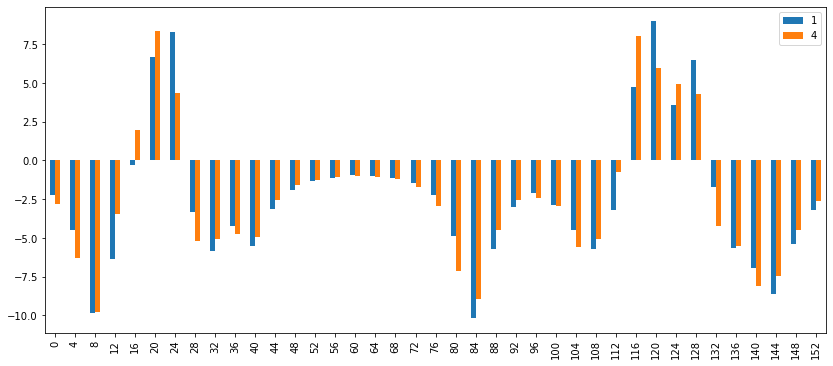

In [7]:
#Angle difference of next point
tac1 = track_angle_change(track_dir(track_line,track,spacing=1,visualize = False), track_line, track, visualize = False)
#Angle difference 8 points down the track
tac4 = track_angle_change(track_dir(track_line,track,spacing=4,visualize = False), track_line, track, visualize = False)
df = pd.DataFrame({'1':tac1,'4':tac4})
fig = plt.figure(figsize = (14,6))
ax = fig.add_subplot(111)
df.groupby(df.index // 4).mean().set_index(np.array(df.index)[::4]).plot.bar(ax=ax)

### Track Zones: Center, Left, Right

In [8]:
def mid_point(xy1,xy2):
    return [(xy1[0]+xy2[0])/2,(xy1[1]+xy2[1])/2]

left_mid = []
for coord1,coord2 in zip(track.outer_border,track.center_line):
    left_mid.append(mid_point(coord1,coord2))
left_mid = np.array(left_mid)

right_mid = []
for coord1,coord2 in zip(track.inner_border,track.center_line):
    right_mid.append(mid_point(coord1,coord2))
right_mid = np.array(right_mid)

## Import Racing Line from K1999

In [9]:
# Import automatically generated racing line from k1999
from numpy import array
#Read in racing line from .py
fname = './racelines-reInvent2019_track-3000-4-2020-07-27-151501.py'
with open(fname, "r") as file:
    racingline = eval(file.read())

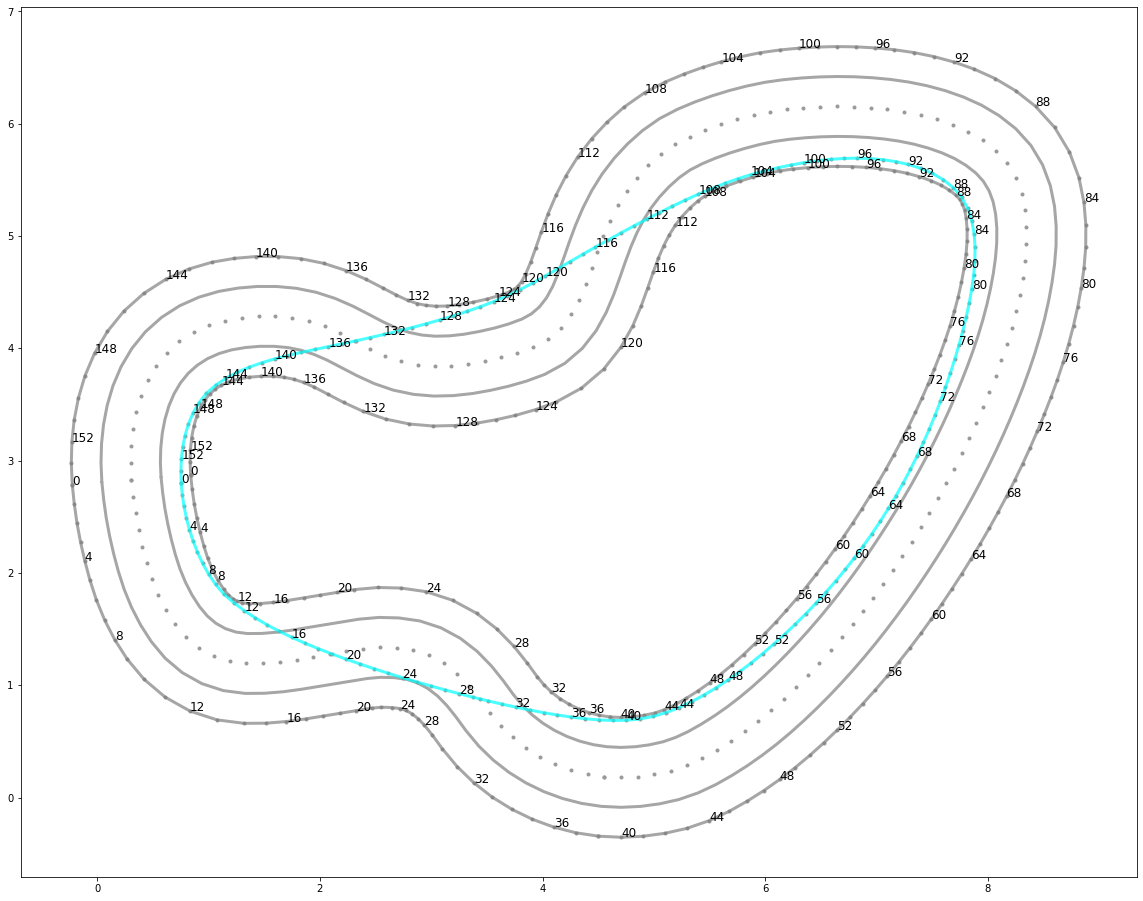

In [10]:
# When off center_line, the racingline can be slightly in front or after waypoints
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(1, 1, 1)
pu._plot_coords(ax, LineString(track.center_line))
# for i, p in enumerate(track.center_line):
#         if i % 2 == 0:
#             ax.annotate(i, (p[0], p[1]), color='k',size=12)

pu._plot_line(ax, LineString(track.inner_border),'grey')
pu._plot_coords(ax, LineString(track.inner_border))
for i, p in enumerate(track.inner_border):
        if i % 4 == 0:
            ax.annotate(i, (p[0], p[1]), color='k',size=12)

pu._plot_line(ax, LineString(track.outer_border),'grey')
pu._plot_coords(ax, LineString(track.outer_border))
for i, p in enumerate(track.outer_border):
        if i % 4 == 0:
            ax.annotate(i, (p[0], p[1]), color='k',size=12)

pu._plot_line(ax, LineString(left_mid),'grey')
pu._plot_line(ax, LineString(right_mid),'grey')

pu._plot_line(ax, LineString(racingline),'cyan')
pu._plot_coords(ax,LineString(racingline))
for i, p in enumerate(racingline):
        if i % 4 == 0:
            ax.annotate(i, (p[0], p[1]), color='k',size=12)
#pu._plot_line(ax,LineString(racingline))

In [11]:
dist_racing=[]
line = racingline
for i in np.arange(len(line[:-1])):
    j = ((i+2) % len(line))-1
    dist_racing.append(np.linalg.norm(line[j] - line[i]))
    
print('Total distance of central line: %.1f' % sum(dist))
print('Total distance of racing line: %.1f' % sum(dist_racing))

Total distance of central line: 23.1
Total distance of racing line: 19.1


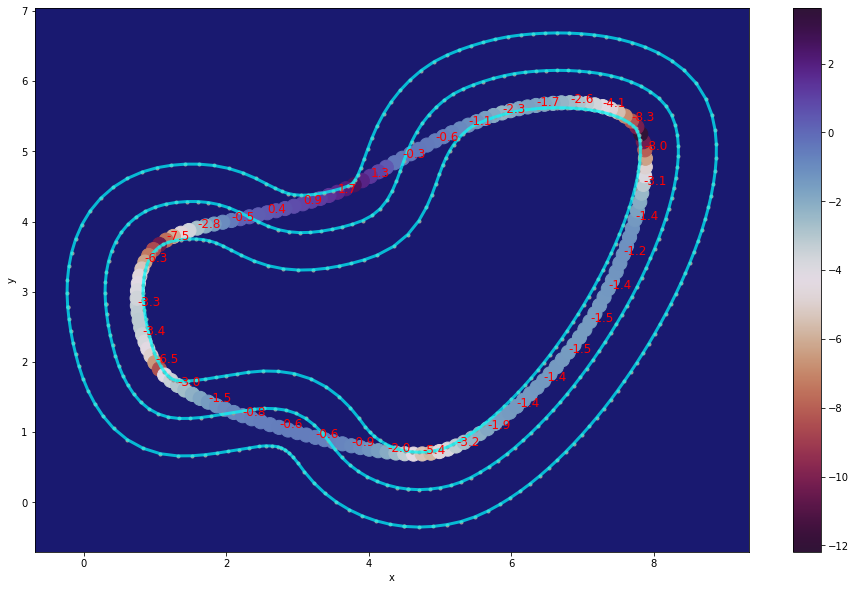

In [12]:
tac_racing = track_angle_change(track_dir(racingline,track,visualize = False), racingline, track, visualize = True)

## Racing line turning angles

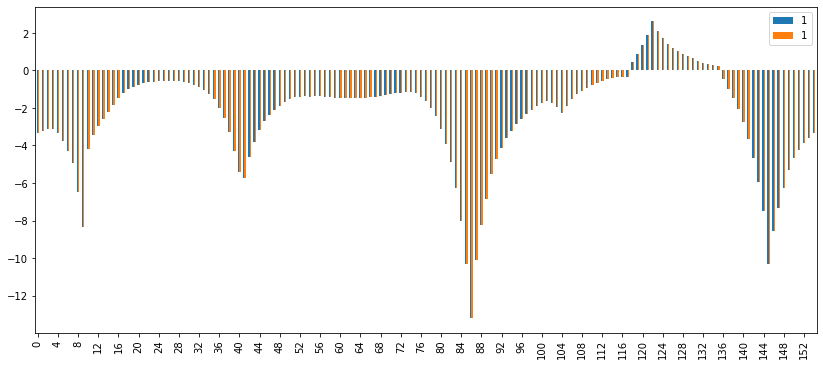

In [13]:
#Angle difference of next point
tac1 = track_angle_change(track_dir(racingline,track,spacing=1,visualize = False), racingline, track, visualize = False)
#Angle difference N points down the track
N=1
tacN = track_angle_change(track_dir(racingline,track,spacing=N,visualize = False), racingline, track, visualize = False)
df = pd.DataFrame({'1':tac1,'N':tacN})
fig = plt.figure(figsize = (14,6))
ax = fig.add_subplot(111)
#df = df.groupby(df.index // 4).mean().set_index(np.array(df.index)[::4])
df = df.groupby(df.index // 1).mean().set_index(np.array(df.index)[::1])
df = df.rename(columns={'N': N})
df.plot.bar(ax=ax)
plt.xticks(np.array(df.index)[::4],np.array(df.index)[::4]);

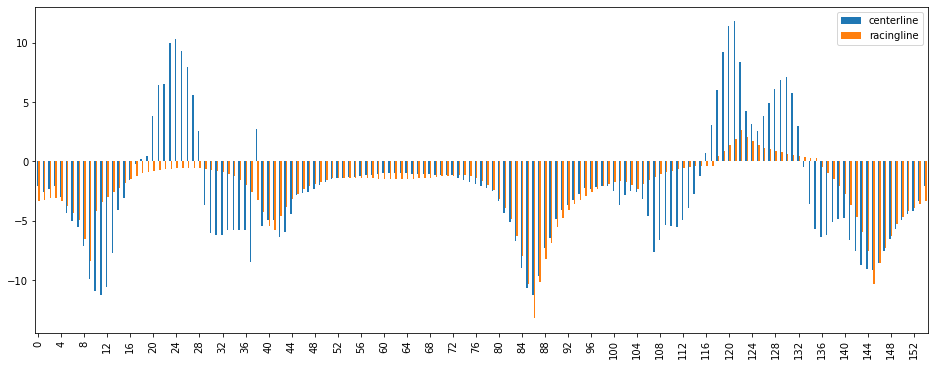

In [14]:
#Angle difference centerline vs racingline
df = pd.DataFrame({'centerline':tac_track,'racingline':tacN})
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(111)
df.groupby(df.index // 1).mean().set_index(np.array(df.index)[::1]).plot.bar(ax=ax)
plt.xticks(np.array(df.index)[::4],np.array(df.index)[::4]);

## Speed waypoints

In [15]:
def dist_ab(a,b):
    x1 = a[0];y1 = a[1];x2 = b[0];y2 = b[1]
    return ((x1-x2)**2+(y1-y2)**2)**0.5
i = 0
point_dist = []
for (a,b) in zip(track.center_line,track.center_line[1:]):
    i+=1
    if dist_ab(a,b) == 0:
        print('duplicate point', i-1)
        break
    point_dist.append(dist_ab(a,b))

point_dist_rl = []
for (a,b) in zip(racingline,racingline[1:]):
    i+=1
    if dist_ab(a,b) == 0:
        print('duplicate point', i-1)
        break
    point_dist_rl.append(dist_ab(a,b))
    
print('Average distance between central line points {:0.4f}'.format(sum(point_dist)/len(point_dist)))
print('Min distance between central line points {:0.4f}'.format(max(point_dist)))
print('Max distance between central line points {:0.4f}'.format(min(point_dist)))
print('Average distance between racing line points {:0.4f}'.format(sum(point_dist_rl)/len(point_dist_rl)))
print('Min distance between central line points {:0.4f}'.format(max(point_dist_rl)))
print('Max distance between central line points {:0.4f}'.format(min(point_dist_rl)))

duplicate point 38
Average distance between central line points 0.1510
Min distance between central line points 0.1511
Max distance between central line points 0.1509
Average distance between racing line points 0.1242
Min distance between central line points 0.1349
Max distance between central line points 0.1055


In [16]:
tacN_abs = tacN
tacN_abs = [abs(x) for x in tacN_abs]

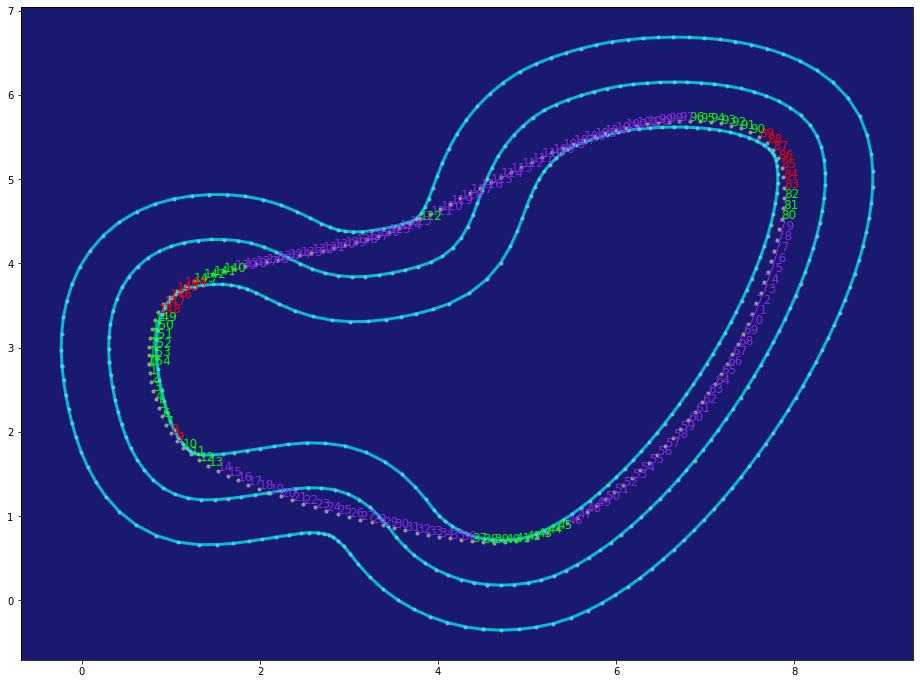

In [49]:
steering = []
for tac in tacN:
    if tac <= 0:
        steering.append('left')
    else:
        steering.append('right')

g=[]; y=[]; r=[]; m=[]
for i,a in enumerate(tacN_abs):
    
    if a < 2.5:
        g.append(i)
    elif a < 6:
        y.append(i)
    else:
        r.append(i)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('midnightblue')

line = LineString(track.inner_border)
pu._plot_coords(ax, line)
pu._plot_line(ax, line)

line = LineString(track.outer_border)
pu._plot_coords(ax, line)
pu._plot_line(ax, line)

line = LineString(track.center_line)
pu._plot_coords(ax, line)
pu._plot_line(ax, line)

line = LineString(racingline)
pu._plot_coords(ax, line)
for i, p in enumerate(racingline):
    if i in r:
        c = 'red'
    elif i in y:
        c = 'lime'
    else:
        c = 'blueviolet'
    ax.annotate(i, (p[0], p[1]), color=c, size=12)

In [61]:
steering.index('right')

118

In [54]:
print('green =', list(g))
print('\n')
print('yellow =', list(y))
print('\n')
print('red =', list(r))
print('\n')
print('car_steering =', list(steering))

green = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139]


yellow = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 37, 38, 39, 40, 41, 42, 43, 44, 45, 80, 81, 82, 90, 91, 92, 93, 94, 95, 96, 122, 140, 141, 142, 143, 149, 150, 151, 152, 153, 154]


red = [8, 9, 83, 84, 85, 86, 87, 88, 89, 144, 145, 146, 147, 148]


car_steering = ['left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left',

## Print racing line coordinates

In [21]:
%pprint
(racingline).tolist()

Pretty printing has been turned OFF


[[0.75464103, 2.8021818], [0.76415034, 2.69703798], [0.77979132, 2.5924164], [0.80134723, 2.48853314], [0.82862984, 2.3855855], [0.86161505, 2.28378878], [0.9007539, 2.18349076], [0.94671672, 2.08518731], [1.00049691, 1.98962212], [1.06314198, 1.89777386], [1.13728916, 1.81186694], [1.22554462, 1.73555719], [1.32054055, 1.66479493], [1.42107173, 1.59888559], [1.52641102, 1.53736319], [1.63601614, 1.47981871], [1.74935924, 1.42576385], [1.86593041, 1.37465062], [1.98529305, 1.32594281], [2.10717069, 1.27914019], [2.23181949, 1.23372173], [2.3589412, 1.18955623], [2.48691254, 1.1470081], [2.61501907, 1.10611988], [2.74300488, 1.06681451], [2.87077582, 1.02903811], [2.99829734, 0.99274264], [3.12556005, 0.95788533], [3.25256514, 0.92443225], [3.37931584, 0.89237052], [3.50581021, 0.86173404], [3.63204451, 0.83258037], [3.75799945, 0.80507314], [3.88365509, 0.77940386], [4.00898432, 0.75583907], [4.13396447, 0.73465008], [4.25854465, 0.71635728], [4.38267801, 0.70153966], [4.50628888, 0.69

## Classify Racing Line in 4 Track Regions

In [22]:
from shapely.geometry import Point, LineString
pts_left=np.zeros(len(track.center_line))
pts_center_left=np.zeros(len(track.center_line))
pts_center_right=np.zeros(len(track.center_line))
pts_right=np.zeros(len(track.center_line))

line_data = zip(racingline,track.outer_border,left_mid,track.center_line,right_mid,track.inner_border)
for i, (pt_rl,pt_L,pt_CL,pt_C,pt_CR,pt_R) in enumerate(line_data):
    line_L = LineString([tuple(pt_L),tuple(pt_CL)])
    line_CL = LineString([tuple(pt_CL),tuple(pt_C)])
    line_CR = LineString([tuple(pt_CR),tuple(pt_C)])
    line_R = LineString([tuple(pt_R),tuple(pt_CR)])
    if line_L.distance(Point(pt_rl)) < 1e-1:
        pts_left[i] = 1
    elif line_CL.distance(Point(pt_rl)) < 1e-1:
        pts_center_left[i] = 1
    elif line_CR.distance(Point(pt_rl)) < 1e-1:
        pts_center_right[i] = 1
    elif line_R.distance(Point(pt_rl)) < 1e-1:
        pts_right[i] = 1       
        
df_rl = pd.DataFrame(data={'racing line':racingline.tolist(),
                           'point number':np.arange(1,len(track.center_line)+1),
                            'left':pts_left.tolist(),
                            'center left':pts_center_left.tolist(),
                            'center right':pts_center_right.tolist(),
                            'right':pts_right.tolist()})

## Print Track Regions

In [23]:
# left = df_rl[df_rl['left']==1]['point number']
# print('left: ',list(left))
# print('\n')

# center_left = df_rl[df_rl['center left']==1]['point number']
# print('center left:', list(center_left))
# print('\n')

# center_right = df_rl[df_rl['center right']==1]['point number']
# print('center right:', list(center_right))
# print('\n')

# right = df_rl[df_rl['right']==1]['point number']
# print('right:', list(right))
# print('\n')

# center = df_rl[(df_rl['center right']==1) | (df_rl['center left']==1)]['point number']
# print('center:', ','.join(str(i) for i in list(center)))
# print('\n')

# left = df_rl[df_rl['left']==1]['point number']
# print('left: ',list(left))
# print('\n')

# right = df_rl[df_rl['right']==1]['point number']
# print('right:', list(right))
# print('\n')


# left = df_rl[(df_rl['left']==1)|(df_rl['center left']==1)]['point number']
# print('left: ',list(left))
# print('\n')

# right = df_rl[(df_rl['right']==1)|(df_rl['center right']==1)]['point number']
# print('right:', list(right))
# print('\n')

#','.join(str(i) for i in df_rl['point number'])